In [1]:
import os
import sys
os.chdir('/home/msun415/induction/')
sys.path.append('/home/msun415/induction/my_data_efficient_grammar')
import argparse 
from rdkit import Chem
from rdkit.Chem import rdchem
from multiprocessing import Pool
from tqdm import tqdm
from itertools import permutations
from functools import reduce
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
from collections import defaultdict, Counter
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import json
from rdkit.Chem.rdmolops import FastFindRings
from itertools import accumulate, product
from copy import deepcopy
from private.molecule_graph import MolGraph
import networkx.algorithms.chordal as chordal
import os
import networkx as nx
import pandas as pd
import pickle
from src.draw.graph import draw_graph
import networkx as nx
import random
from collections.abc import Iterable
import re
import pickle
import glob
from pathlib import Path
from src.algo.hg import llm_call, grammar_inference
from src.grammar.hg import Grammar
import concurrent.futures

def flatten(nested_iterable):
    if isinstance(nested_iterable, Iterable):
        return sum([flatten(iterable) for iterable in nested_iterable], [])
    else:
        return [nested_iterable]

# SEED = 0
# random.seed(SEED)
# np.random.seed(SEED)
# import pygsp as gsp
# from pygsp import graphs

from src.api.get_motifs import prepare_images
import openai
openai.api_key = open('notebooks/api_key.txt').readline().rstrip('\n')

/home/msun415/miniconda3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
num_seeds = 5
for dataset in ['isocyanates','acrylates','chain_extenders']:
    for ablate in ['ablate_merge','ablate_root','ablate_tree']:
        seedstr_lambda = lambda seed: f"{ablate}-{seed}"

        for seed in range(1,num_seeds+1):
            seedstr = seedstr_lambda(seed)
            globals()[f'grammar_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-{seedstr}.pkl', 'rb'))
            globals()[f'trees_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/trees-{dataset}-{seedstr}.pkl', 'rb'))
        grammar = deepcopy(grammar_1)    
        for i in range(2,num_seeds+1):
            grammar.combine(locals()[f'grammar_{i}'])
            pickle.dump(grammar, open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-{ablate}-1-{i}-all.pkl', 'wb+'))       


In [16]:
num_seeds = 10
for dataset in ['acrylates']:
    seedstr_lambda = lambda seed: f"{seed}-more-specific"
    for seed in range(1,num_seeds+1):
        seedstr = seedstr_lambda(seed)
        globals()[f'grammar_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-{seedstr}.pkl', 'rb'))
        globals()[f'trees_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/trees-{dataset}-{seedstr}.pkl', 'rb'))
    grammar = deepcopy(grammar_1)    
    for i in range(2,num_seeds+1):
        grammar.combine(locals()[f'grammar_{i}'])
        pickle.dump(grammar, open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-1-{i}-all.pkl', 'wb+'))

In [2]:
num_seeds = 10
dataset = 'acrylates'
seedstr_lambda = lambda seed: f"{seed}-more-specific"
for seed in range(1,num_seeds+1):
    seedstr = seedstr_lambda(seed)
    globals()[f'grammar_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-{seedstr}.pkl', 'rb'))
    globals()[f'trees_{seed}'] = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/trees-{dataset}-{seedstr}.pkl', 'rb'))

In [3]:
for seed in range(1,num_seeds+1):
    globals()[f'smis_{seed}'] = list(globals()[f'grammar_{seed}'].mol_lookup)
smile_set = set(smis_1)

In [4]:
def compare_rhs(r1, r2):
    gm = GraphMatcher(r1, r2, node_match=lambda x,y: x['label']==y['label'])
    for sub in gm.isomorphisms_iter():
        map_ext_nodes = set([sub[n] for n in r1 if n[0] == 'e'])
        if map_ext_nodes == set([n for n in r2 if n[0] == 'e']):
            return True
    return False

def compare(set_1, set_2, iou=False):
    if not iou and len(set_1) != len(set_2):
        return False
    if iou:
        intersect = 0
    for i in range(len(set_1)-1,-1,-1):
        # try to find it in set_2
        r1 = set_1[i]
        found = -1
        for j in range(len(set_2)-1,-1,-1):
            r2 = set_2[j]
            if len(r1) != len(r2):
                continue
            if compare_rhs(r1, r2):
                found = j
                break
            if found != -1:
                break
        if not iou:
            if found == -1:
                return False
            set_2.pop(found)
        if iou and found != -1:
            intersect += 1            
    if iou:
        return intersect/(len(set_1)+len(set_2)-intersect)
    else:
        return True



def compare_rulesets():
    rule_multisets = defaultdict(list)
    for smi in list(smile_set):
        for grammar, trees, smis in [(globals()[f'grammar_{seed}'], globals()[f'trees_{seed}'], globals()[f'smis_{seed}']) for seed in range(1,num_seeds+1)]:    
            idx = smis.index(smi)    
            rule_gs = []
            for i in range(len(trees[idx])):
                data = trees[idx].nodes[i]
                symbol = data['symbol']
                rule_str = data['rule']
                rule_idx = grammar.rule_idx_lookup[smi][symbol][rule_str]
                rule = grammar.hrg.rules[rule_idx]
                rhs_g = rule.rhs.visualize(path='', return_g=True)
                rule_gs.append(rhs_g)
            rule_multisets[smi].append(rule_gs)
    # compare two rule sets
    res = {}
    for smiles in rule_multisets:
        multisets = rule_multisets[smiles]
        count = 0
        for i in range(len(multisets)):
            for j in range(i+1, len(multisets)):
                count += compare(multisets[i], multisets[j], iou=True)
        res[smiles] = count/(len(multisets)*(len(multisets)-1)/2)


def bradley_terry(pairwise_results, num_debaters, max_iterations=100, tolerance=1e-6):
    # Step 1: Initialize skill levels for each debater (theta values)
    theta = [1.0 for _ in range(num_debaters)]  # Initial guess, could be any positive number
    for iteration in range(max_iterations):
        theta_old = theta[:]  # Keep a copy of the old theta values for convergence check
        # Step 2: For each debater i, update their theta based on all pairwise matches
        for i in range(num_debaters):
            numerator = 0.0
            denominator = 0.0
            # Step 3: Iterate over all match results involving debater i
            for (i_prime, j, S_i_prime) in pairwise_results:
                if i_prime == i:  # i played against j
                    numerator += S_i_prime  # Sum of debater i's scores
                    denominator += S_i_prime + (1 - S_i_prime) * (theta[j] / theta[i])  # Bradley-Terry denominator
                elif j == i:  # i played against i_prime
                    numerator += (1 - S_i_prime)  # Sum of debater j's scores
                    denominator += (1 - S_i_prime) + S_i_prime * (theta[i_prime] / theta[i])
            # Step 4: Update theta for debater i using the Bradley-Terry scaling formula
            theta[i] = numerator / denominator
        # Step 5: Check for convergence
        if max(abs(theta[i] - theta_old[i]) for i in range(num_debaters)) < tolerance:
            break
    # Step 6: Rank debaters by theta values (higher is better)
    ranked_debaters = sorted(range(num_debaters), key=lambda x: theta[x], reverse=True)
    return ranked_debaters, theta  # The winner is the debater with the highest theta value


def llm_debate(smiles, cot_1, cot_2, prompt_path):
    base_prompt = ''.join(open(prompt_path).readlines())
    base_prompt = base_prompt.replace('<smiles>', smiles)
    prompt = f"Analysis A:\n\n{cot_1}\n\nAnalysis B:\n\n{cot_2}"
    logprobs = llm_call([], None, prompt=base_prompt+'\n'+prompt, return_logprobs=True)
    log_probs = [None, None]
    for logprob in logprobs:
        if logprob['token'] == 'A':
            log_probs[0] = logprob['logprob']
        elif logprob['token'] == 'B':
            log_probs[1] = logprob['logprob']
    if None in log_probs:
        return None
    return np.exp(log_probs)/sum(np.exp(log_probs))


def read_tree_cot(folder):
    path_1 = os.path.join(folder, 'motifs_cot.txt')
    path_2 = os.path.join(folder, 'root_cot.txt')
    lines_1 = open(path_1).readlines()
    lines_2 = open(path_2).readlines()
    clique_cot = ''.join(lines_1)
    root_cot = ''.join(lines_2)
    paths = glob.glob(os.path.join(folder, 'tree/*.txt'))
    paths.sort(key=lambda x: os.path.getmtime(x))
    tree_cots = []
    for i, path in enumerate(paths):    
        stem = Path(path).stem
        nodes = stem.split(':')[0].split('-')
        a, b = map(int, nodes)
        step = f"Step {i+1}: Join Motif {a} (positive) with Motif {b} (negative).\n"
        step_cot = ''.join(open(path).readlines())
        cot = step + f"Reasoning: {step_cot}\n"
        tree_cots.append(cot)
    tree_cot = clique_cot + '\n\n' + root_cot + '\n\n' + '\n'.join(tree_cots)
    return tree_cot


def round_robin_tournament(smis):
    # rank which grammar did the best job at decomposing a mol
    winner = {}
    rankings = {}
    for smi in smis:
        pairwise_res = []
        tree_cots = [None for _ in range(num_seeds)]
        for i in range(num_seeds):
            folder = globals()[f'grammar_{i+1}'].folder_lookup[smi]
            tree_cots[i] = read_tree_cot(folder)
        for i in range(num_seeds):
            for j in range(i+1, num_seeds):
                res = llm_debate(smi, tree_cots[i], tree_cots[j], f'/home/msun415/induction/data/{dataset}/api_mol_hg_7.txt')
                print(res)
                pairwise_res.append((i, j, res[0]))
        ranking, theta = bradley_terry(pairwise_res, num_seeds)
        winner[smi] = ranking[0]
        rankings[smi] = ranking 
    return winner, rankings  


def swiss_tournament(smis, num_rounds=4, cache=None):
    def _tournament(smi):
        tree_cots = [None for _ in range(num_seeds)]        
        for i in range(num_seeds):
            folder = globals()[f'grammar_{i+1}'].folder_lookup[smi]
            tree_cots[i] = read_tree_cot(folder)
        pairwise_results = []
        debater_scores = {i: 0 for i in range(num_seeds)}
        for round_num in range(num_rounds):
            sorted_debaters = sorted(debater_scores.keys(), key=lambda x: debater_scores[x], reverse=True)
            if num_seeds % 2:
                pairings = range(round_num%2, num_seeds-(round_num+1)%2, 2)
            else:
                pairings = range(0,num_seeds-1,2)
            match_pairs = [(sorted_debaters[i], sorted_debaters[i + 1]) for i in pairings]
            for i, j in match_pairs:                
                res = llm_debate(smi, tree_cots[i], tree_cots[j], f'/home/msun415/induction/data/{dataset}/api_mol_hg_7.txt')  
                S_i = res[0]              
                S_j = 1 - S_i
                if S_i == 1 or S_i == 0:
                    print("bad")
                pairwise_results.append((i, j, S_i))
                debater_scores[i] += S_i
                debater_scores[j] += S_j
        return smi, pairwise_results
    if cache and os.path.exists(cache):
        winner, rankings = pickle.load(open(cache, 'rb'))
        smis = [smi for smi in smis if smi not in winner]
    else:
        winner = {}
        rankings = {}        
    import threading 
    lock = threading.Lock()
    with concurrent.futures.ThreadPoolExecutor(50) as executor:
        # Submit tasks to the thread pool
        futures = [
            executor.submit(_tournament, smi)
            for smi in tqdm(smis, desc="submitting generation tasks")
        ]
        for future in concurrent.futures.as_completed(futures):
            smi, pairwise_results = future.result()
            ranked_debaters, _ = bradley_terry(pairwise_results, num_seeds)
            with lock:
                winner[smi] = ranked_debaters[0]
                rankings[smi] = ranked_debaters
                pickle.dump((winner, rankings), open(cache, 'wb+'))
                print(f"{len(winner)}/{len(smis)} done")
    return winner, rankings 



In [12]:

smis = list(grammar_1.mol_lookup)
# winner, rankings = swiss_tournament(smis, num_rounds=4)
cache_path = f"data/api_mol_hg/{dataset}-swiss.pkl"
winner, rankings = swiss_tournament(smis, num_rounds=4, cache=cache_path)


submitting generation tasks: 100%|██████████| 32/32 [00:00<00:00, 471.03it/s]


1/32 done
2/32 done
3/32 done
4/32 done
5/32 done
6/32 done
7/32 done
8/32 done
9/32 done
10/32 done
11/32 done
12/32 done
13/32 done
14/32 done
15/32 done
16/32 done
17/32 done
18/32 done
19/32 done
20/32 done
21/32 done
22/32 done
23/32 done
24/32 done
25/32 done
26/32 done
27/32 done
28/32 done
29/32 done
30/32 done
31/32 done
32/32 done


In [13]:
winner_count = defaultdict(int)
for smi in winner:
    winner_count[winner[smi]] += 1
winner_count

# pickle.dump((winner, rankings), open('/home/msun415/winner_and_rankings_tmp.pkl', 'wb+'))
# winner, rankings = pickle.load(open('/home/msun415/winner_and_rankings_tmp.pkl', 'rb'))

# bad_smiles = 'Cc1c(-c2c3nc4c(nc3c(-c3c(C)cc(-c5ccc6-c7ccccc7C(C)(C)c6c5)s3)s2)-c2cccc3cccc-4c23)scc1'
# bad_smiles in grammar_1.rule_idx_lookup


defaultdict(int, {5: 3, 2: 3, 1: 5, 0: 3, 9: 2, 4: 3, 8: 6, 6: 5, 3: 2})

In [ ]:

check = []
orig_smiles = open('data/api_mol_hg/hopv_smiles.txt').readlines()
# print(len(orig_smiles))
orig_smi_set = set()
for orig_smi, smi in zip(orig_smiles, smis):
    mol = Chem.MolFromSmiles(orig_smi)
    Chem.Kekulize(mol)
    orig_smi_set.add(Chem.MolToSmiles(mol))
print(orig_smi_set.difference(set(smis)))
print(set(smis).difference(orig_smi_set))

In [15]:
for k in tqdm(range(1,num_seeds+1), "k"):
    G_pool = None
    trees_pool = defaultdict(list)
    for smi in tqdm(smis, "combining rule sets"):
        for i in range(k):
            r = rankings[smi][i]
            winner_g = locals()[f'grammar_{r+1}']
            winner_trees = locals()[f'trees_{r+1}']
            tree_index = list(winner_g.mol_lookup).index(smi)
            winner_tree = winner_trees[tree_index]
            trees_pool[smi] += [winner_tree]
            rule = winner_g.mol_lookup[smi]
            mol = Chem.MolFromSmiles(smi)
            g = Grammar(mol, rule)
            Grammar._init_mol_lookup(g)
            if G_pool is None:
                G_pool = g
            else:
                G_pool.combine(g)
    grammar_inference(G_pool, trees_pool)
    pickle.dump(G_pool, open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-swiss-pool-{k}.pkl', 'wb+'))

k: 100%|██████████| 10/10 [01:39<00:00,  9.94s/it]


In [17]:
dataset


'acrylates'

In [ ]:
import moses

dataset = 'polymers_117'
seed = 1
gen_smiles = open(f'/home/msun415/induction/data/api_mol_hg/smiles-{dataset}-{seed}-more-specific.txt').readlines()
test_smiles = open(f'/home/msun415/induction/data/api_mol_hg/polymers_117_test_smiles.txt').readlines()
train_smiles = open(f'/home/msun415/induction/data/api_mol_hg/polymers_117_train_smiles.txt').readlines()
# moses.get_all_metrics(gen_smiles[:10000], test=test_smiles, n_jobs=50)

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.Chem.QED import qed
from moses.metrics.SA_Score import sascorer
def logP(mol):
    return Chem.Crippen.MolLogP(mol)
def SA(mol):
    return sascorer.calculateScore(mol)
def QED(mol):
    return qed(mol)
def weight(mol):
    return Descriptors.MolWt(mol)
def features(mol):
    return [logP(mol), SA(mol), QED(mol), weight(mol)]

import multiprocessing as mp
def fitting(gen_smiles, train_smiles, num_clusters=10000):
    with mp.Pool(100) as p:
        gen_feats = p.map(features, [Chem.MolFromSmiles(smi) for smi in tqdm(gen_smiles)])
    with mp.Pool(100) as p:
        train_feats = p.map(features, [Chem.MolFromSmiles(smi) for smi in tqdm(train_smiles)])
    from sklearn.cluster import KMeans
    print("fit start")
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=1, n_init=1).fit(train_feats)
    centroids = kmeans.cluster_centers_
    print("fit finish")
    cluster_assignments = kmeans.predict(gen_feats)
    clusters = [set() for _ in range(num_clusters)]
    for i in range(len(gen_feats)):
        clusters[cluster_assignments[i]].add(i)
    train_cluster_assignments = kmeans.predict(train_feats)
    print("predict finish")
    print("train", train_cluster_assignments)
    print("gen", cluster_assignments)
    final_samples = []
    counts = defaultdict(int)
    for i in range(num_clusters):        
        order = sorted(range(num_clusters), key=lambda j:np.linalg.norm(centroids[j]-centroids[i]))
        assert order[0] == i
        for ci, c in enumerate(order):
            if len(clusters[c]):
                sample = random.choice(list(clusters[c]))
                clusters[c].remove(sample)
                counts[ci] += 1
                break
        final_samples.append(sample)
    # print(f"{len(final_samples)} equal mass samples")
    print(f"{counts[0]} equal mass samples")
    return np.array(final_samples)

fitted = fitting(gen_smiles, train_smiles, 10000)

In [ ]:
moses.get_all_metrics(gen_smiles[:10000], test=test_smiles, n_jobs=50)

In [ ]:
G, _ = pickle.load(open(f'data/api_mol_hg/grammar-{dataset}-verbose-ckpt.pkl','rb'))
len(G.folder_lookup)

In [ ]:
print('zip -r acrylates-all.zip ' + ' '.join(G.folder_lookup.values()) + ' data/api_mol_hg-acrylates-verbose.log')

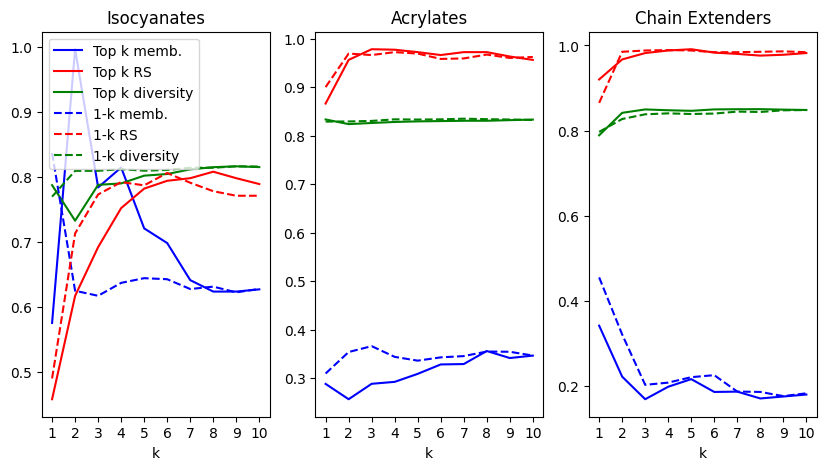

In [10]:
start = 1
num_seeds = 10
start_dataset = 0
num_datasets = 3
fig, axes = plt.subplots(1,num_datasets,figsize=(10,5))
for j in range(start_dataset,num_datasets):
    dataset = ['isocyanates','acrylates','chain_extenders','hopv','ptc'][j]
    titles = ['Isocyanates','Acrylates','Chain Extenders','HOPV','PTC']
    ax = axes[j]
    for i in range(2):
        memb, rs, novelty, unique, diversity = [], [], [], [], []    
        setting = "Top k" if i == 0 else "1-k"
        for k in range(start,num_seeds+1):
            if k == 1:
                seedstr = "pool" if i == 0 else "1-more-specific"
            else:
                seedstr = f"swiss-pool-{k}" if i == 0 else f"1-{k}-all"
            res = json.load(open(f'/home/msun415/induction/data/api_mol_hg/metrics-for-smiles-{dataset}-{seedstr}.json'))
            
            memb.append(res['membership'])
            rs.append(res['RS'])
            novelty.append(res['novelty'])
            unique.append(res['unique'])
            diversity.append(res['diversity'])
        ax.set_xticks(range(start,num_seeds+1))
        ax.plot(range(start,num_seeds+1), memb, label=f'{setting} memb.', linestyle='--' if i==1 else '-', c='blue')
        ax.plot(range(start,num_seeds+1), rs, label=f'{setting} RS', linestyle='--' if i==1 else '-', c='red')
        # ax.plot(range(1,num_seeds+1), novelty, label=f'{setting} novelty')
        # ax.plot(range(1,num_seeds+1), unique, label=f'{setting} unique')
        ax.plot(range(start,num_seeds+1), diversity, label=f'{setting} diversity', linestyle='--' if i==1 else '-', c='green')
        if j == 0:
            ax.legend()
        ax.autoscale()
        ax.set_title(titles[j])
        ax.set_xlabel("k")

In [4]:
def check_chain_extender(smis):
    # Define SMARTS patterns for various chain extenders
    members = 0
    for smi in smis:
        mol = Chem.MolFromSmiles(smi)
        mol.SubstructMatches(Chem.MolFromSmiles("CO"))
        members += match
    return members/len(smis)


def check_hopv(smis):
    thio = Chem.MolFromSmiles('[cH:1]1[cH:2][cH:3][cH:4][s:5]1') # thiophene
    members = 0
    for smi in smis:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        members += bool(mol.GetSubstructMatches(thio))
    return members/len(smis)


def check_acrylate(smis):
    # Define the SMARTS pattern for the Isocyanate group (-N=C=O)
    acrylate_smarts = 'C=CC(=O)O'
    acrylate_pattern = Chem.MolFromSmarts(acrylate_smarts)
    members = 0
    for smi in smis:
        mol = Chem.MolFromSmiles(smi)
        members += mol.HasSubstructMatch(acrylate_pattern)    
    return members/len(smis)



smis = open('/home/msun415/test.txt').readlines()
check_acrylate(smis)

1.0

In [10]:
dataset = 'hopv'
g1 = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-swiss-pool-5.pkl', 'rb'))
g2 = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-1-5-all.pkl', 'rb'))
print(len(g1.hrg.rules), len(g2.hrg.rules))
rules1 = g1.hrg.rules
rules2 = g2.hrg.rules

rule_multiset1 = [rule.rhs.visualize(path='', return_g=True) for rule in rules1]
rule_multiset2 = [rule.rhs.visualize(path='', return_g=True) for rule in rules2]
print(compare(deepcopy(rule_multiset1), deepcopy(rule_multiset2)))


sum(g1.hrg.counts), sum(g2.hrg.counts)

2951 2950
False


(28158, 28158)

In [6]:
dataset='ptc'
g1 = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-swiss-pool-5.pkl', 'rb'))
g2 = pickle.load(open(f'/home/msun415/induction/data/api_mol_hg/grammar-{dataset}-1-5-all.pkl', 'rb'))
print(len(g1.hrg.rules), len(g2.hrg.rules))
rules1 = g1.hrg.rules
rules2 = g2.hrg.rules

rule_multiset1 = [rule.rhs.visualize(path='', return_g=True) for rule in rules1]
rule_multiset2 = [rule.rhs.visualize(path='', return_g=True) for rule in rules2]
print(compare(deepcopy(rule_multiset1), deepcopy(rule_multiset2)))

sum(g1.hrg.counts), sum(g2.hrg.counts)

2301 2290
False


(9399, 9399)